In [40]:
import numpy as np
import cv2 as cv # SIFT descriptors
import os # file reading

# Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt

In [41]:
# Read images

images = []
labels = []

for subdir in os.listdir("fruit_dataset"):
    for file_name in os.listdir("fruit_dataset/" + subdir):
        label = file_name.split("_")[0:2] # Extract label
        labels.append(label) # Add label to dataset
        
        # Make images readable by OpenCV
        image = cv.imread("fruit_dataset/" + subdir + "/" + file_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        images.append(image) # Add image to dataset
images = np.array(images)
labels = np.array(labels)

print(images.shape, labels.shape)

(1655, 300, 300, 3) (1655, 2)


In [42]:
color_histograms = []
num_bins = 80
for image in images:
    image_lab = cv.cvtColor(image, cv.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv.split(image_lab)
    l_hist = cv.calcHist([l_channel], [0], None, [num_bins], [0, 256])
    a_hist = cv.calcHist([a_channel], [0], None, [num_bins], [0, 256])
    b_hist = cv.calcHist([b_channel], [0], None, [num_bins], [0, 256])
    hist_features = np.concatenate((l_hist, a_hist, b_hist)).flatten()
    hist_features /= np.sum(hist_features)
    color_histograms.append(hist_features)

color_histograms = np.array(color_histograms)

{'rotten_peach': 57, 'rotten_pomegranate': 44, 'fresh_pomegranate': 44, 'fresh_peach': 34, 'rotten_strawberry': 36, 'fresh_strawberry': 35}


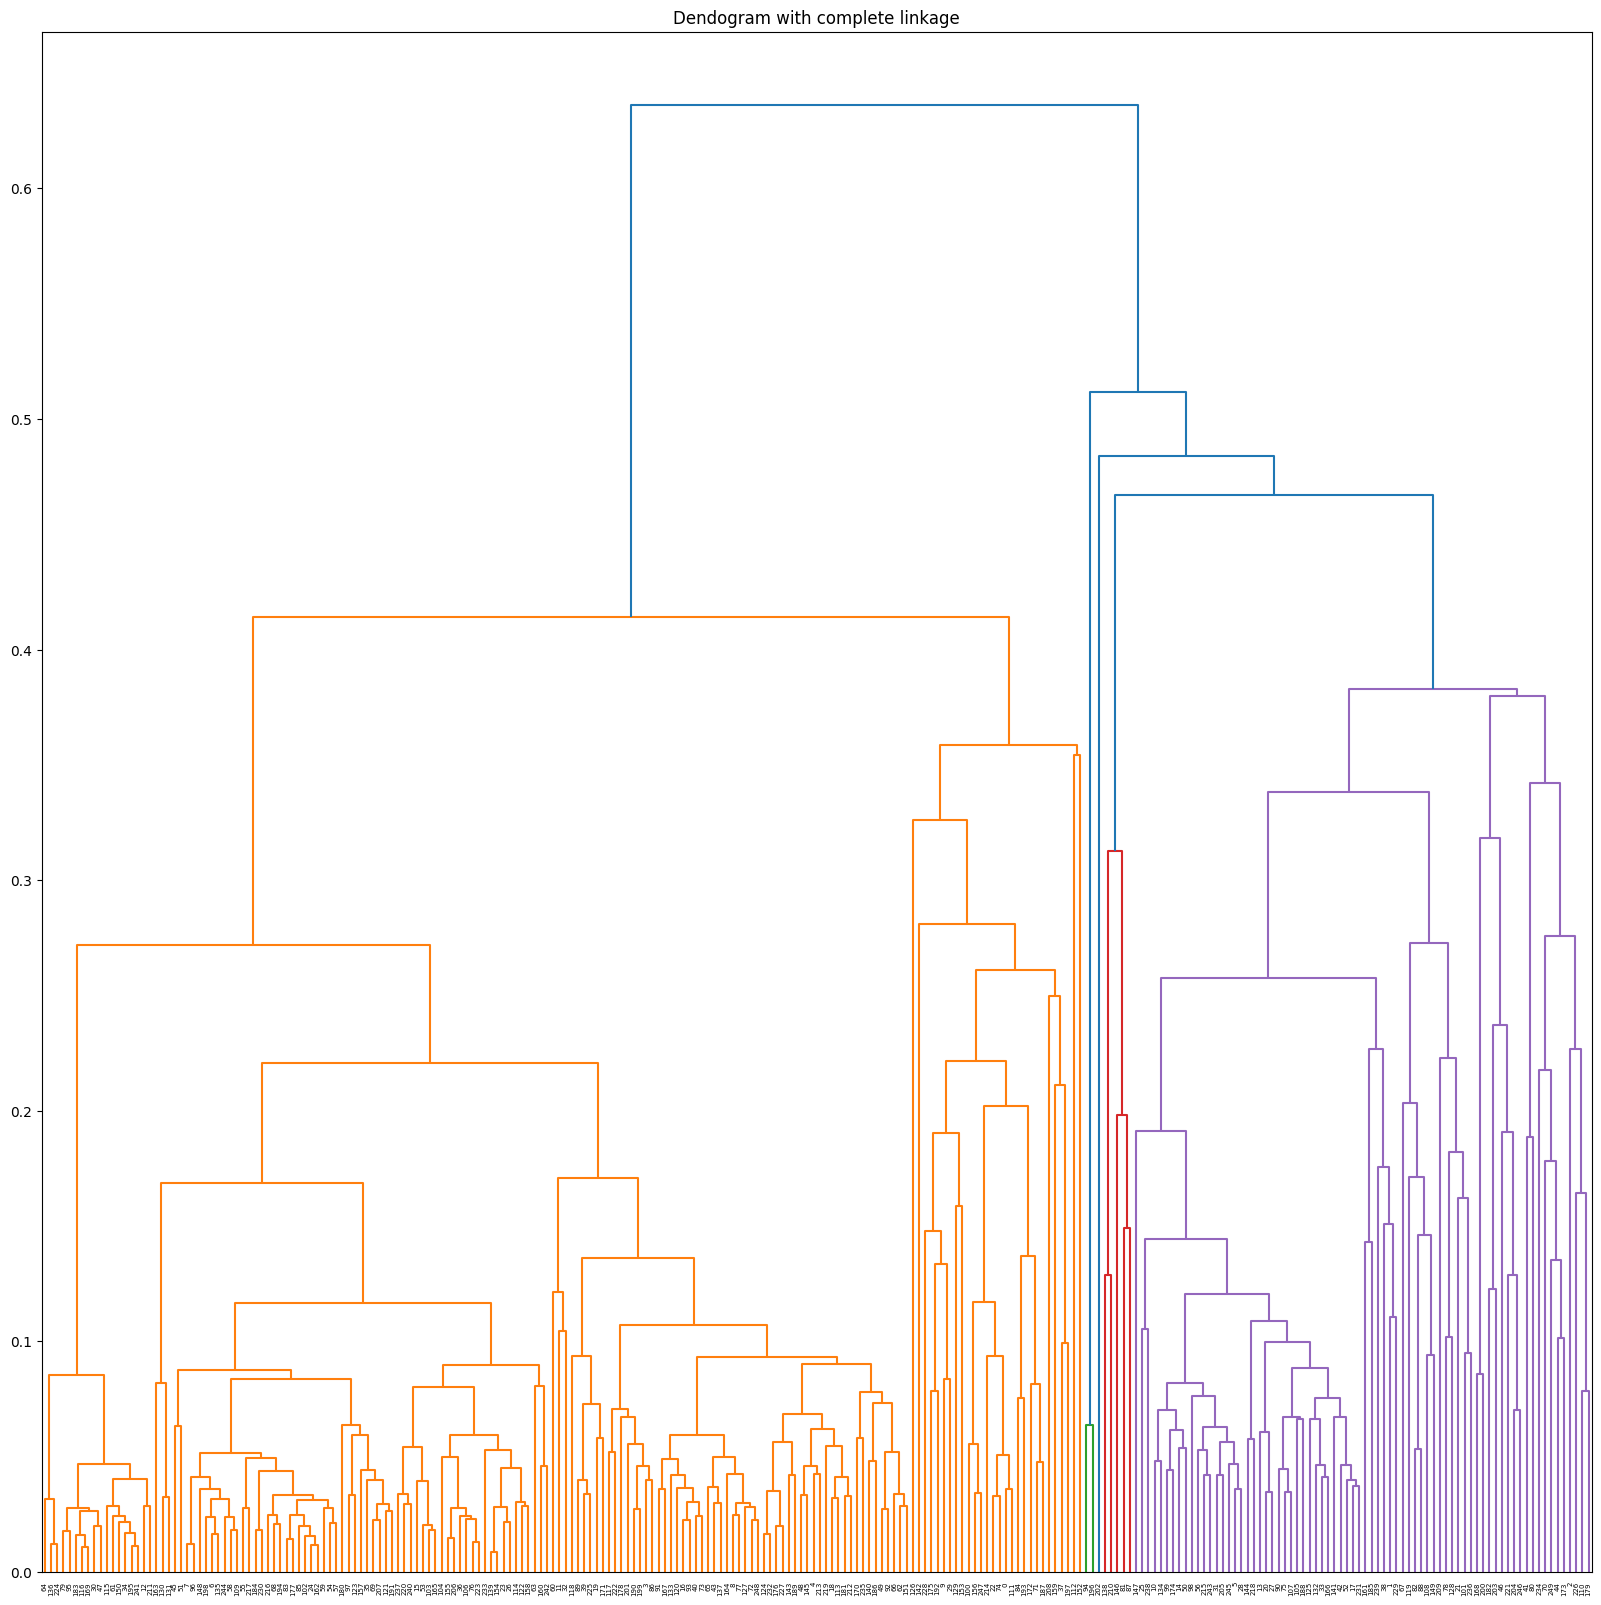

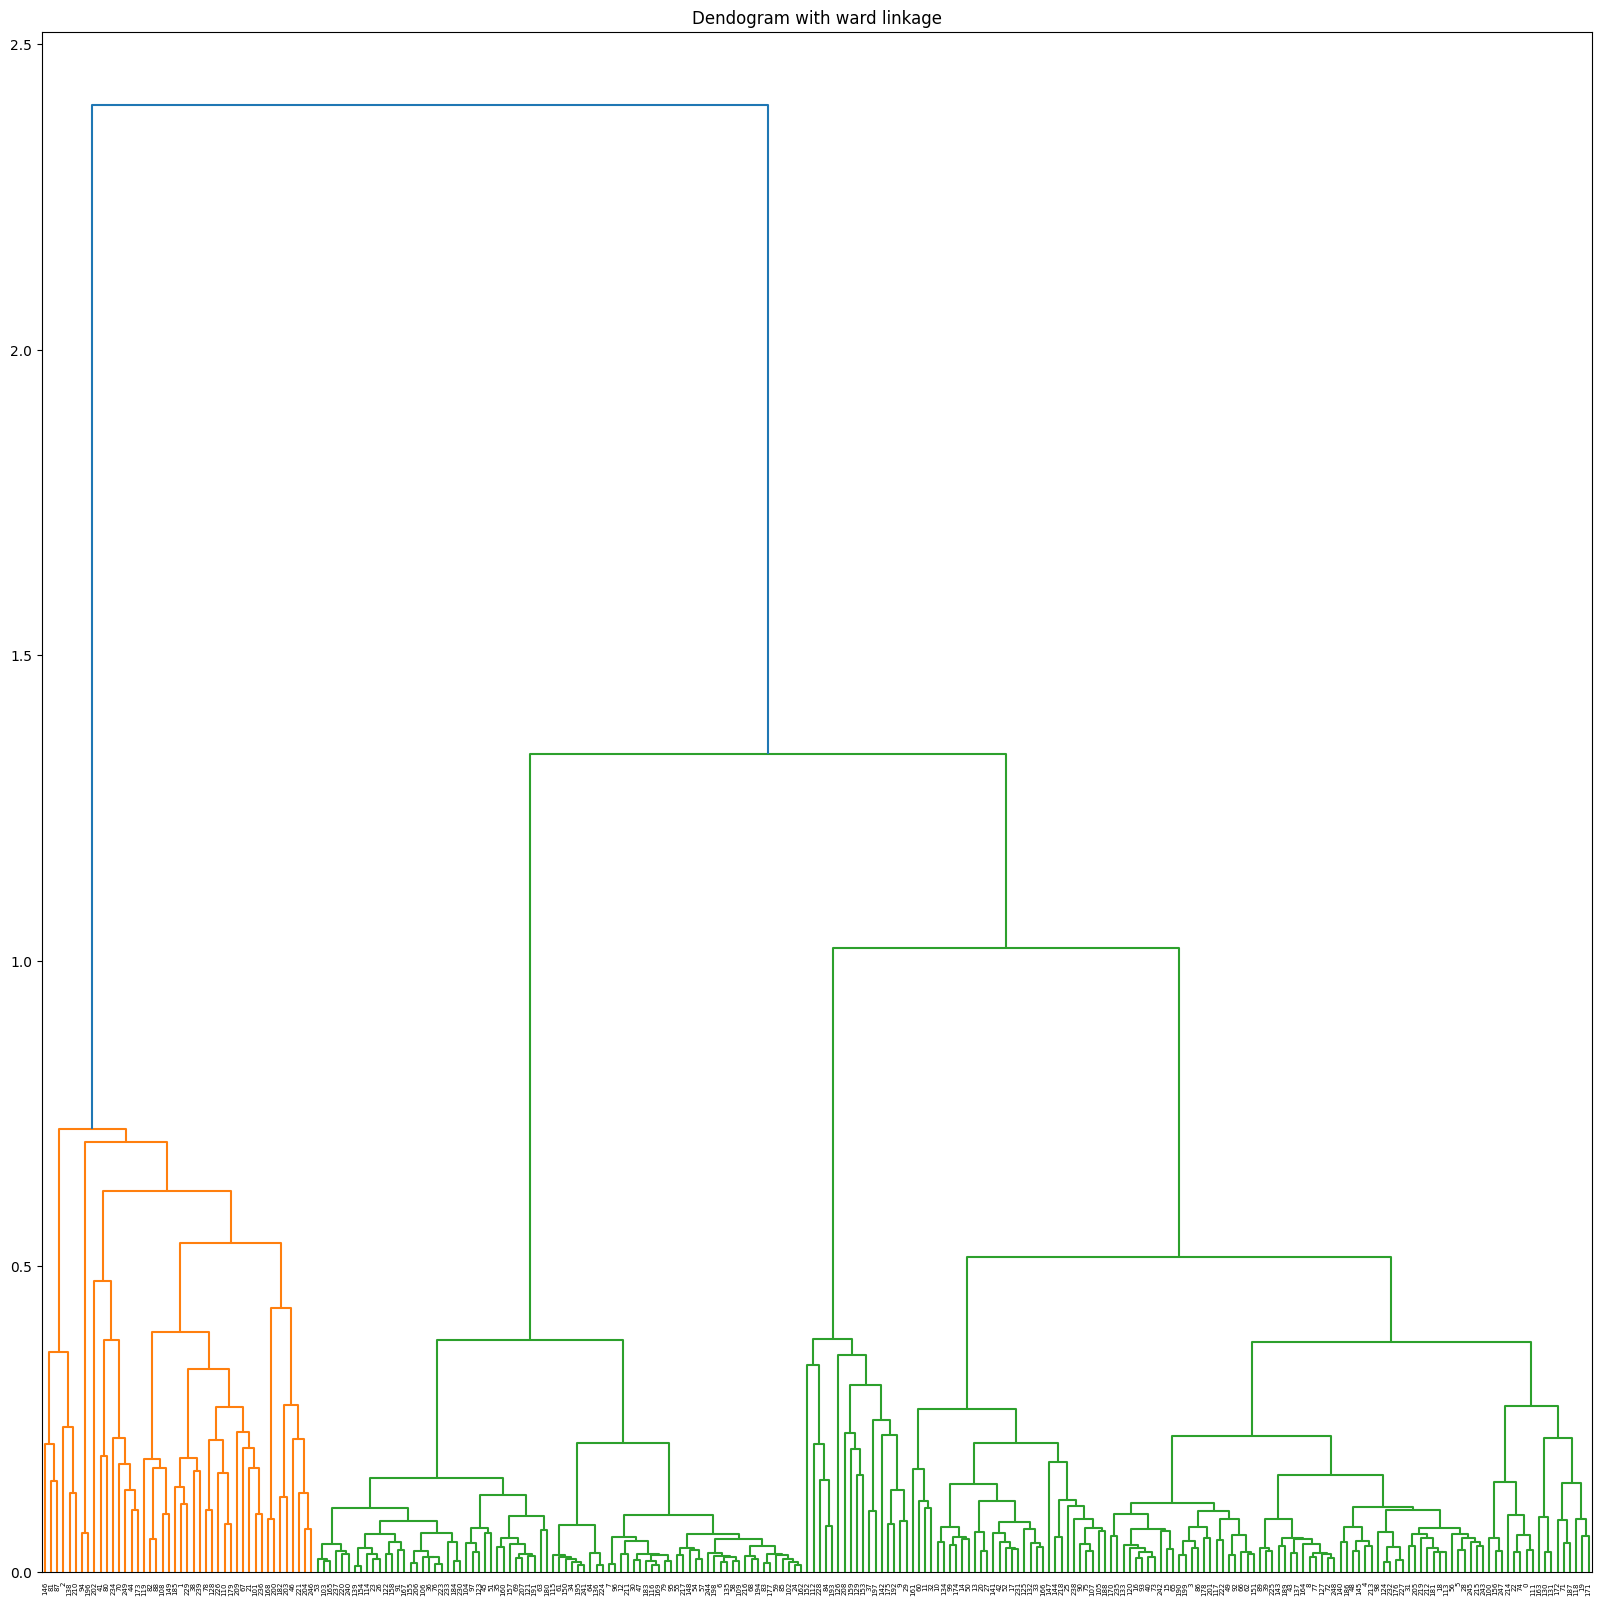

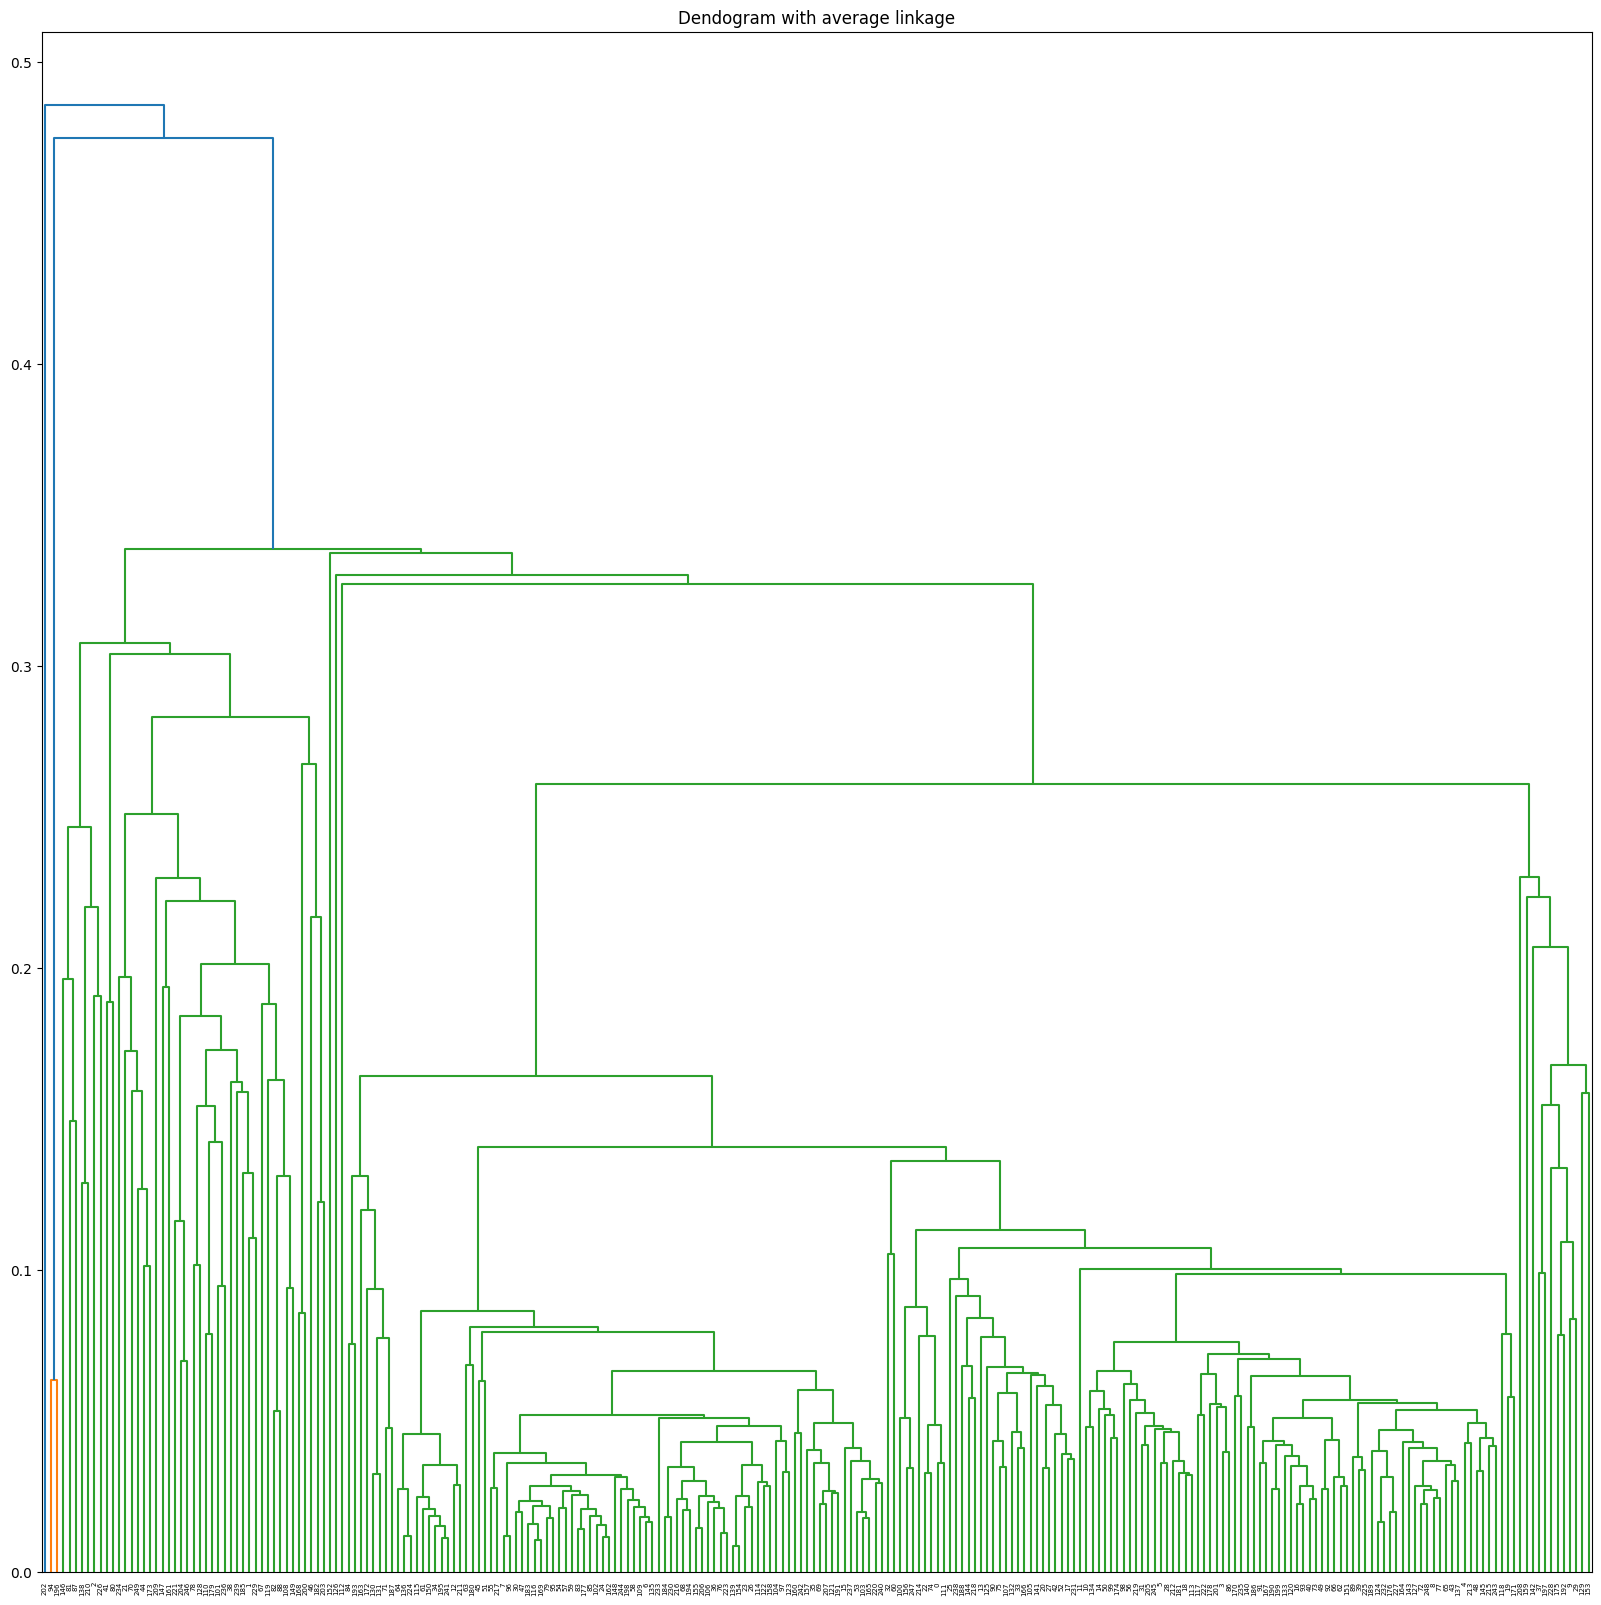

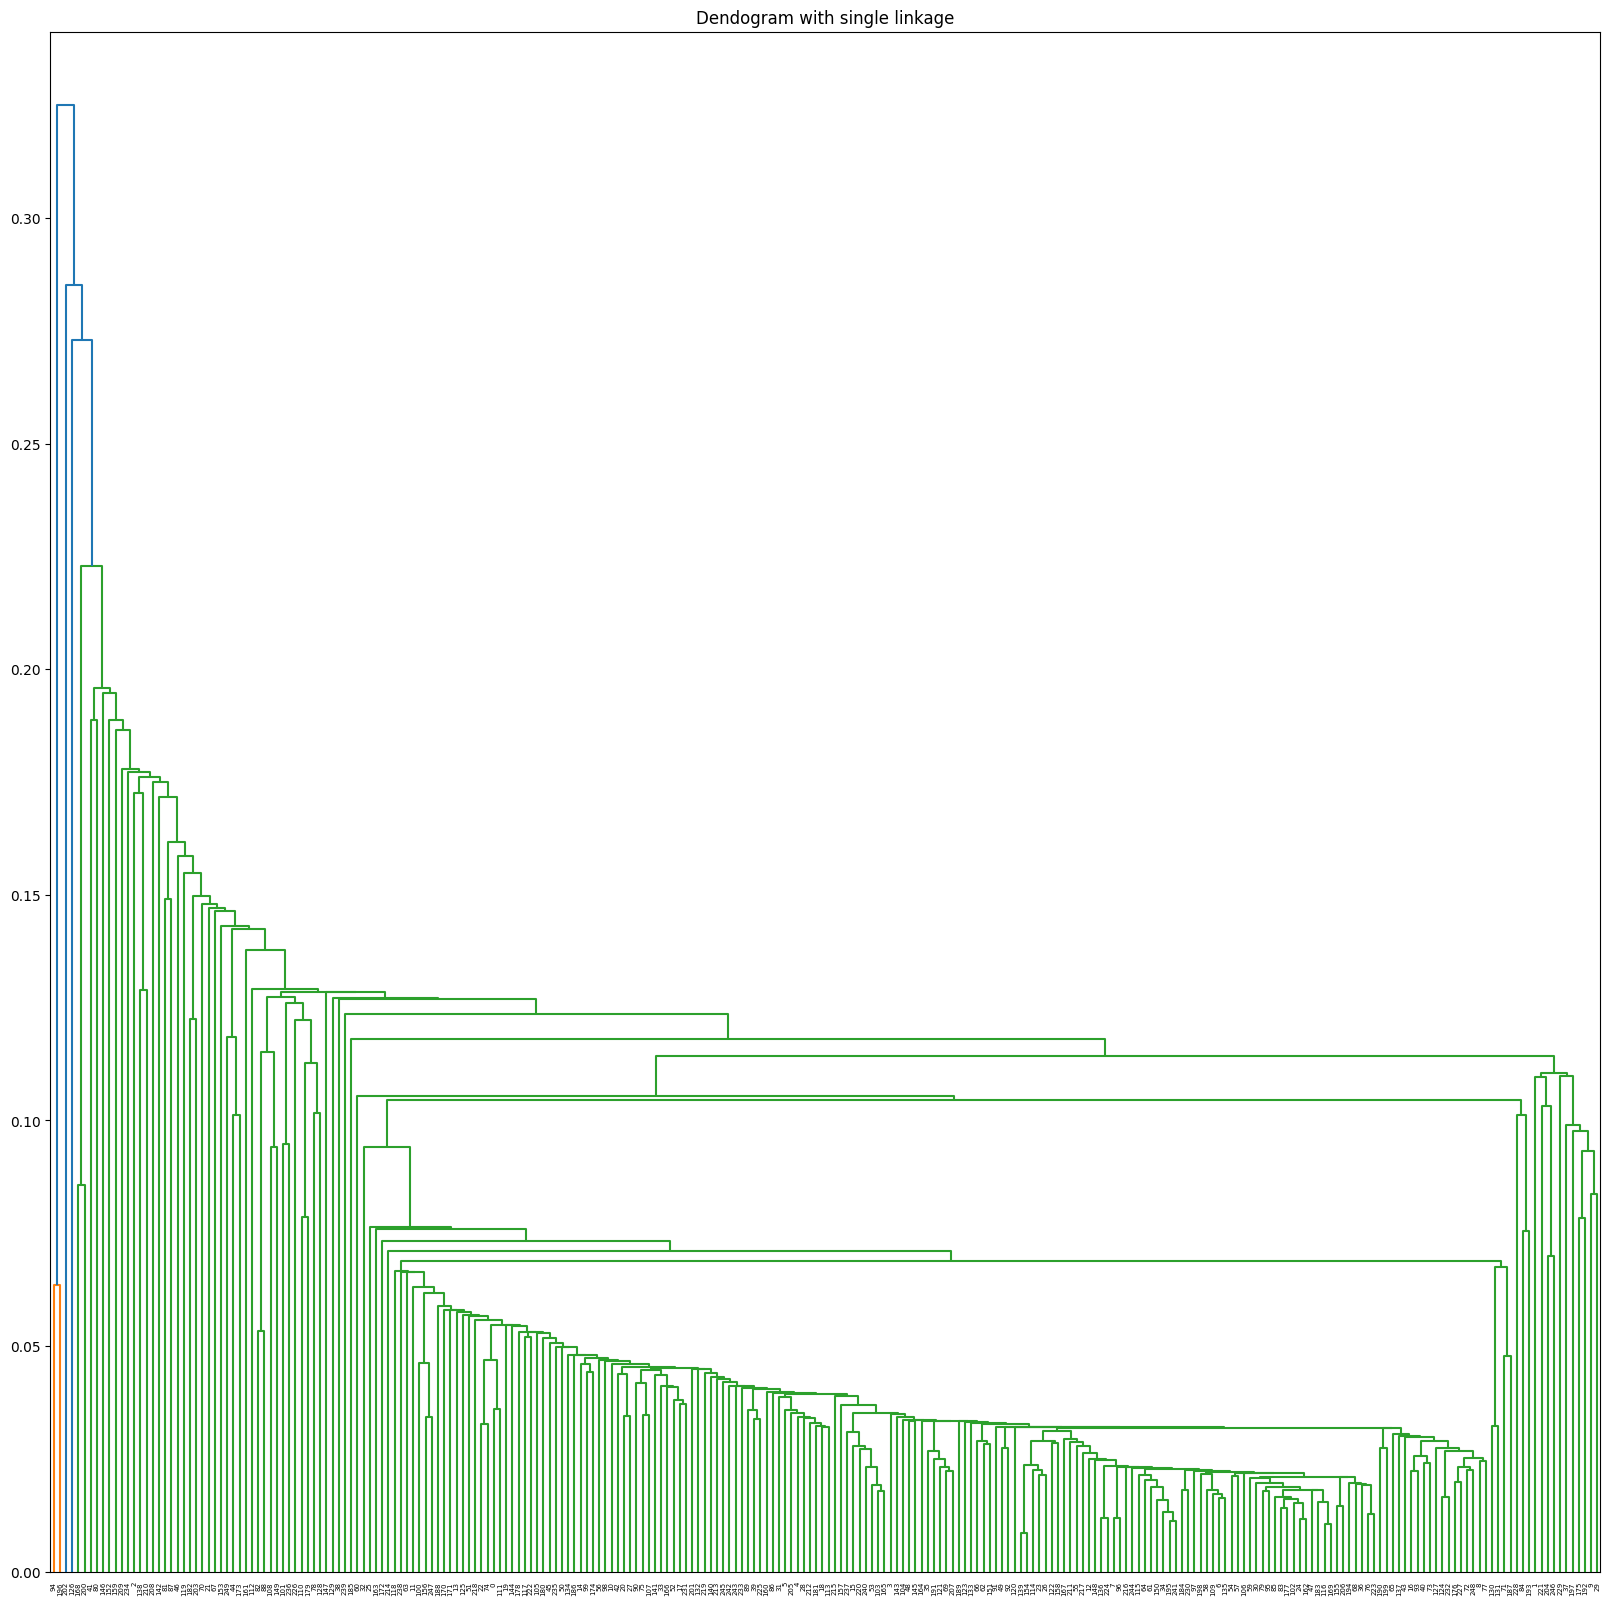

In [43]:
# Build a dendogram
np.random.seed(678)
subset_indices = np.random.choice(len(color_histograms), size=250, replace=False)

image_descriptors_subset = color_histograms[subset_indices]
labels_subset = labels[subset_indices]

# Look at the random data to make sure it's somewhat uniform and well-representative
freqs = dict()
for label in labels_subset:
    label_str = '_'.join(label)
    if label_str not in freqs:
        freqs[label_str] = 0
    freqs[label_str] += 1
print(freqs)

plt.figure(figsize =(20, 20))
plt.title('Dendogram with complete linkage')
dendrogram1 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='complete')))
plt.show()


plt.figure(figsize =(20, 20))
plt.title('Dendogram with ward linkage')
dendrogram2 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='ward')))
plt.show()

plt.figure(figsize =(20, 20))
plt.title('Dendogram with average linkage')
dendrogram3 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='average')))
plt.show()

plt.figure(figsize =(20, 20))
plt.title('Dendogram with single linkage')
dendrogram4 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='single')))
plt.show()

Ward linkage appears to have the most natural division into 6 clusters as expected, though the dendograms are concerning because neither shows 6 distinct clusters, despite our classes clearly being divided into 6.

In [44]:
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean').fit(color_histograms)

In [45]:
# Print results
cluster_labels = clustering.labels_

clusters = {}
for idx, cluster_id in enumerate(cluster_labels):
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(labels[idx])

for cluster_id, data_points in clusters.items():
    print("Cluster " + str(cluster_id) + ":")
    print("Total data points: " + str(len(data_points)))
    label_strs, label_counts = np.unique([str(label) for label in data_points], return_counts=True)
    for label, count in zip(label_strs, label_counts):
        print("Label " + str(label) + ": " + str(count) + " occurrences")
    print()

Cluster 0:
Total data points: 250
Label ['fresh' 'peach']: 8 occurrences
Label ['fresh' 'pomegranate']: 21 occurrences
Label ['fresh' 'strawberry']: 11 occurrences
Label ['rotten' 'peach']: 54 occurrences
Label ['rotten' 'pomegranate']: 118 occurrences
Label ['rotten' 'strawberry']: 38 occurrences

Cluster 1:
Total data points: 656
Label ['fresh' 'peach']: 89 occurrences
Label ['fresh' 'pomegranate']: 141 occurrences
Label ['fresh' 'strawberry']: 117 occurrences
Label ['rotten' 'peach']: 156 occurrences
Label ['rotten' 'pomegranate']: 39 occurrences
Label ['rotten' 'strawberry']: 114 occurrences

Cluster 5:
Total data points: 71
Label ['fresh' 'peach']: 8 occurrences
Label ['fresh' 'pomegranate']: 9 occurrences
Label ['fresh' 'strawberry']: 11 occurrences
Label ['rotten' 'peach']: 8 occurrences
Label ['rotten' 'pomegranate']: 21 occurrences
Label ['rotten' 'strawberry']: 14 occurrences

Cluster 3:
Total data points: 314
Label ['fresh' 'peach']: 98 occurrences
Label ['fresh' 'pomegranat

**Analysis**

The spread here is almost even in some clusters and only cluster 0 has one class that "dominates" it. There is very little correlation between clusters and actual classifications, even compared to the SIFT approach, suggesting that color histograms may be an even less accurate approach. This may be caused by the fact that color is extremely sensitive to noise and changes in brightness, while image gradients are less so. I reduced the bin size to try to mitigate that affect by categorizing similar colors in the same bin, but the accuracy was largely unaffected.